## Creating TFRecord files for UNet-based segmentation

U-Net: Convolutional Networks for Biomedical Image Segmentation  
Olaf Ronneberger, Philipp Fischer and Thomas Brox  
http://arxiv.org/abs/1505.04597


### DATA ORGANISATION

The image list is used like this:

```json
images = ['phase','rfp']

set1/
  phase/
    
  gfp/
    0001_gfp.tif
    0002_gfp.tif
    ...
  rfp/
    0001_rfp.tif
    0002_rfp.tif
  ...
  labels/
    0001_mask.tif
    0002_mask.tif
    ...
  weights/
    0001_weights.tif  # NOTE(arl): these are calculated
    0002_weights.tif
    ...
set2/
```

### STEPS
1. Calculate the weightmaps for the images 
2. Create the TFRecord file


### Set up the parameters

In [1]:
# training data filename
DATA_PATH = '/Users/nathanday/lowe_lab/training_data'
# NOTE TO SELF (NAT) THINK THE OLD WEIGHT FILES+DIRs NEED TO BE DELETED BEFORE NEW ONES ARE MADE
#DATA_PATH = "/home/nathan/analysis/training/training_data"
WEIGHT_AMPLITUDE = 50.
tfrecord_fn = "SHARC_UNet_v3_w0-"+str(WEIGHT_AMPLITUDE)+".tfrecord"

Import the libraries

In [2]:
import os
import re
import json
import enum
import numpy as np
from skimage import io
import matplotlib.pyplot as plt

Helper functions to find files and folders

In [3]:
@enum.unique
class Channels(enum.Enum):
    BRIGHTFIELD = 0 
    GFP = 1
    RFP = 2
    IRFP = 3
    PHASE = 4
    WEIGHTS = 98
    MASK = 99

In [4]:
def read_metadata():
    jfile = os.path.join(DATA_PATH, 'training_metadata.json')
    with open(jfile, 'r') as json_file:
        metadata = json.load(json_file)
    return metadata

In [5]:
metadata = read_metadata()

A function to write out the TFRecord file used by the server to train the models

In [6]:
def write_tfrecord(pth,
                   filename,
                   metadata,
                   weights_dir_base='weights'):
    
    try:
        import tensorflow as tf
    except ImportError:
        raise ImportError("Tensorflow is not installed.")
        
    # NOTE(arl): set the number of output channels as n_input+1, this is a guess though    
    # parse the metadata, set the number of output channels by guessing
    channels = [Channels[c.upper()] for c in metadata.keys() if c not in ('mask', 'weights')]
    num_outputs = len(channels)+1
    
    # _int64 is used for numeric values
    def _int64_feature(value):
        return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

    # _bytes is used for string/char values
    def _bytes_feature(value):
        return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

    # _floats is used for float values
    def _float_feature(value):
        return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

    def convert_to_mask(truth):
        if truth.ndim == 2:
            unique_labels = [l for l in np.unique(truth).tolist() if l>0]
            print(f'Unique labels in mask: {unique_labels}')
            mask = np.zeros(truth.shape, dtype=np.uint8)
            for i, label in enumerate(unique_labels):
                mask[truth==label] = i+1
            return mask
        
        # otherwise we have a multidimensional mask
        mask = np.zeros(truth.shape[1:], dtype=np.uint8)
        unique_labels = [i+1 for i in range(truth.shape[0])]
        print(f'Unique labels in mask: {unique_labels}')
        for i, label in enumerate(unique_labels):
            mask[truth[i,...]>0] = label
            mask[truth[i,...]>0] = label
        return mask
    
    # set up the writer
    #writer = tf.python_io.TFRecordWriter(os.path.join(pth, filename))
    writer = tf.io.TFRecordWriter(os.path.join(pth, filename))


    for i in range(len(metadata['mask'])):
        
        # get the image data, remove any singleton dimensions 
        print(i)
        for c in channels:
            print(c.name.lower())
            i_data = np.stack([io.imread(os.path.join(DATA_PATH, metadata[c.name.lower()][i]))], axis=-1)

            #i_data = np.stack([io.imread(os.path.join(DATA_PATH, metadata[c.name.lower()[i]]))], axis=-1)
            #i_data = np.stack([io.imread(os.path.join(DATA_PATH, metadata[c.name.lower()][i])) for c in channels], axis=-1)
        
        # get the label data 
        l_data = convert_to_mask(io.imread(os.path.join(DATA_PATH, metadata['mask'][i])))
        
        plt.figure()
        plt.imshow(l_data)
        plt.colorbar()
        plt.show()

        # get the weights data
        w_data = io.imread(os.path.join(DATA_PATH, metadata['weights'][i])).astype(np.float32)

        print(f'Input: {str((i_data.shape, i_data.dtype))}')
        print(f'Output: {str((l_data.shape[0], l_data.shape[1], num_outputs))}')

        # set up TF feature dict
        feature = {'train/image/image': _bytes_feature(i_data.tostring()),
                   'train/image/width': _int64_feature(i_data.shape[1]),
                   'train/image/height': _int64_feature(i_data.shape[0]),
                   'train/image/depth': _int64_feature(i_data.shape[-1]),
                   'train/label/image': _bytes_feature(l_data.tostring()),
                   'train/label/width': _int64_feature(l_data.shape[1]),
                   'train/label/height': _int64_feature(l_data.shape[0]),
                   'train/label/depth': _int64_feature(num_outputs),
                   'train/weight/image': _bytes_feature(w_data.tostring()),
                   'train/weight/width': _int64_feature(w_data.shape[1]),
                   'train/weight/height': _int64_feature(w_data.shape[0]),
                   'train/weight/depth': _int64_feature(1)}

        features = tf.train.Features(feature=feature)
        example = tf.train.Example(features=features)

        # write out the serialized features
        writer.write(example.SerializeToString())

    # close up shop
    writer.close()

### 2. Write out the TFRecord file

0
phase
gfp
rfp
Unique labels in mask: [1]


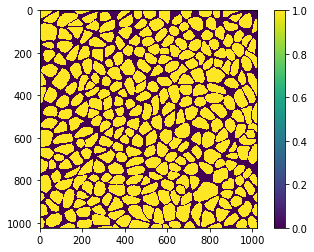

Input: ((1024, 1024, 1), dtype('uint8'))
Output: (1024, 1024, 4)
1
phase
gfp
rfp
Unique labels in mask: [1]


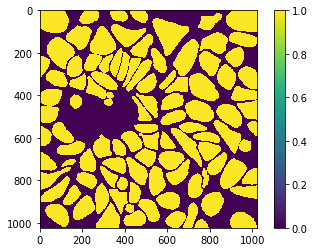

Input: ((1024, 1024, 1), dtype('uint8'))
Output: (1024, 1024, 4)
2
phase
gfp
rfp
Unique labels in mask: [1]


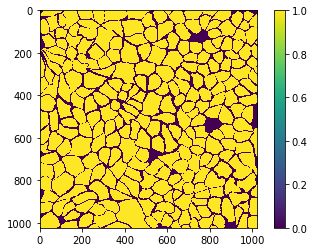

Input: ((1024, 1024, 1), dtype('uint8'))
Output: (1024, 1024, 4)
3
phase
gfp
rfp
Unique labels in mask: [1]


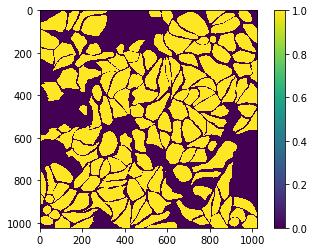

Input: ((1024, 1024, 1), dtype('uint8'))
Output: (1024, 1024, 4)
4
phase
gfp
rfp
Unique labels in mask: [1]


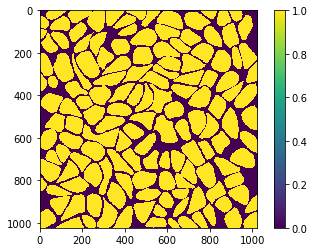

Input: ((1024, 1024, 1), dtype('uint8'))
Output: (1024, 1024, 4)
5
phase
gfp
rfp
Unique labels in mask: [1]


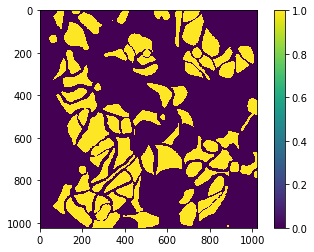

Input: ((1024, 1024, 1), dtype('uint8'))
Output: (1024, 1024, 4)
6
phase
gfp
rfp
Unique labels in mask: [1]


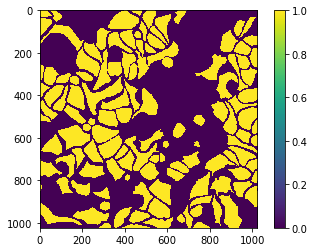

Input: ((1024, 1024, 1), dtype('uint8'))
Output: (1024, 1024, 4)
7
phase
gfp
rfp
Unique labels in mask: [1]


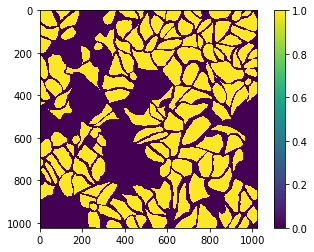

Input: ((1024, 1024, 1), dtype('uint8'))
Output: (1024, 1024, 4)
8
phase
gfp
rfp
Unique labels in mask: [1]


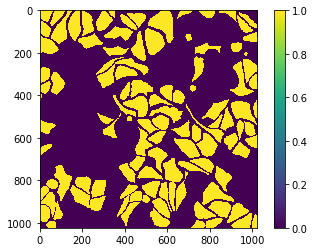

Input: ((1024, 1024, 1), dtype('uint8'))
Output: (1024, 1024, 4)
9
phase
gfp
rfp
Unique labels in mask: [1]


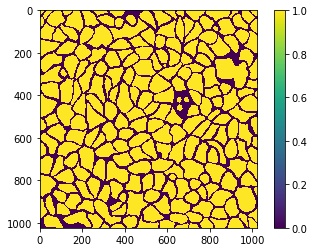

Input: ((1024, 1024, 1), dtype('uint8'))
Output: (1024, 1024, 4)
10
phase
gfp
rfp
Unique labels in mask: [1]


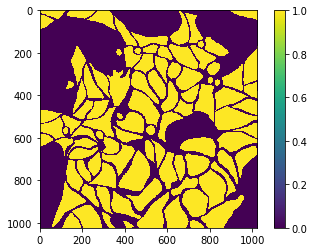

Input: ((1024, 1024, 1), dtype('uint8'))
Output: (1024, 1024, 4)
11
phase
gfp
rfp
Unique labels in mask: [1]


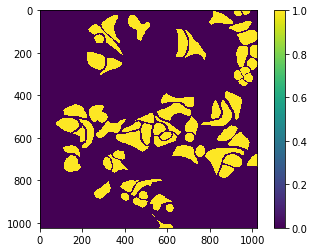

Input: ((1024, 1024, 1), dtype('uint8'))
Output: (1024, 1024, 4)
12
phase
gfp
rfp
Unique labels in mask: [1]


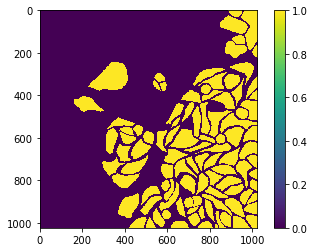

Input: ((1024, 1024, 1), dtype('uint8'))
Output: (1024, 1024, 4)
13
phase
gfp
rfp
Unique labels in mask: [1]


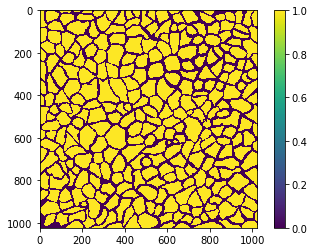

Input: ((1024, 1024, 1), dtype('uint8'))
Output: (1024, 1024, 4)
14
phase
gfp
rfp
Unique labels in mask: [1]


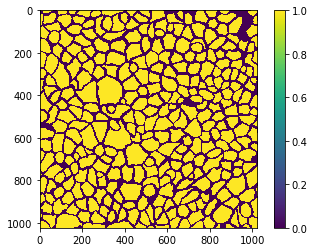

Input: ((1024, 1024, 1), dtype('uint8'))
Output: (1024, 1024, 4)
15
phase
gfp
rfp
Unique labels in mask: [1]


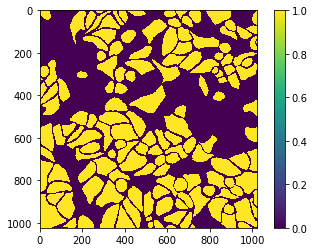

Input: ((1024, 1024, 1), dtype('uint8'))
Output: (1024, 1024, 4)
16
phase
gfp
rfp
Unique labels in mask: [1]


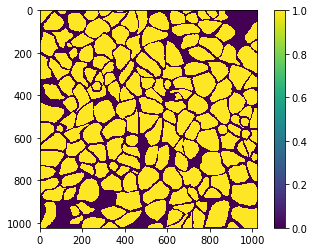

Input: ((1024, 1024, 1), dtype('uint8'))
Output: (1024, 1024, 4)
17
phase
gfp
rfp
Unique labels in mask: [1]


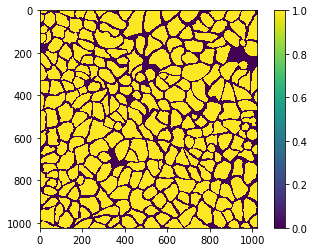

Input: ((1024, 1024, 1), dtype('uint8'))
Output: (1024, 1024, 4)
18
phase
gfp
rfp
Unique labels in mask: [1]


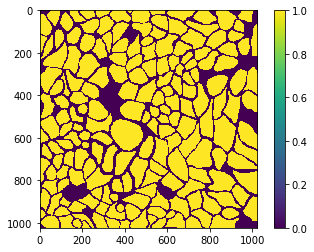

Input: ((1024, 1024, 1), dtype('uint8'))
Output: (1024, 1024, 4)
19
phase
gfp
rfp
Unique labels in mask: [1]


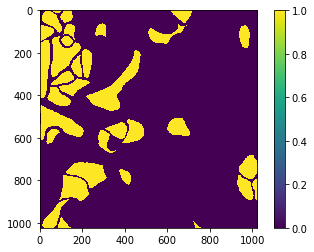

Input: ((1024, 1024, 1), dtype('uint8'))
Output: (1024, 1024, 4)
20
phase
gfp
rfp
Unique labels in mask: [1]


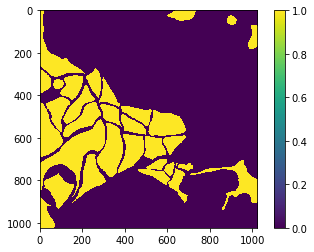

Input: ((1024, 1024, 1), dtype('uint8'))
Output: (1024, 1024, 4)
21
phase
gfp
rfp
Unique labels in mask: [1]


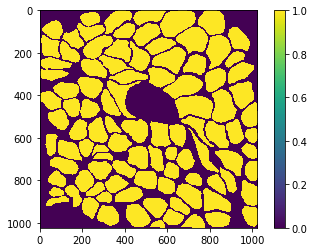

Input: ((1024, 1024, 1), dtype('uint8'))
Output: (1024, 1024, 4)
22
phase
gfp
rfp
Unique labels in mask: [1]


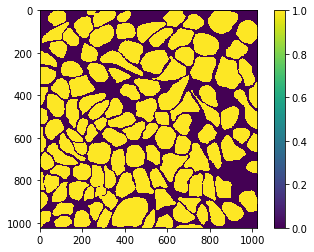

Input: ((1024, 1024, 1), dtype('uint8'))
Output: (1024, 1024, 4)
23
phase
gfp
rfp
Unique labels in mask: [1]


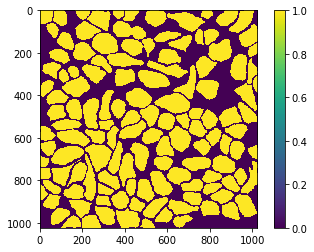

Input: ((1024, 1024, 1), dtype('uint8'))
Output: (1024, 1024, 4)
24
phase
gfp
rfp
Unique labels in mask: [1]


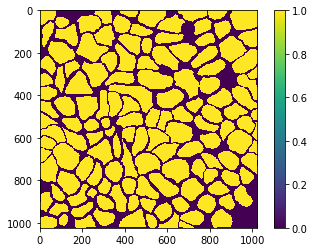

Input: ((1024, 1024, 1), dtype('uint8'))
Output: (1024, 1024, 4)
25
phase
gfp
rfp
Unique labels in mask: [1]


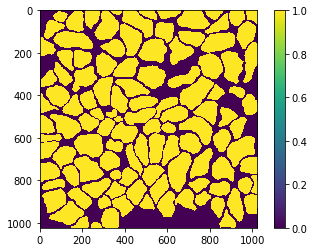

Input: ((1024, 1024, 1), dtype('uint8'))
Output: (1024, 1024, 4)
26
phase
gfp
rfp
Unique labels in mask: [1]


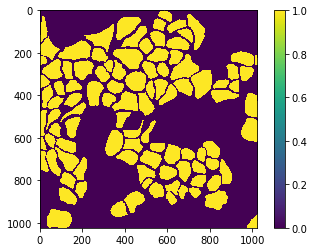

Input: ((1024, 1024, 1), dtype('uint8'))
Output: (1024, 1024, 4)
27
phase
gfp
rfp
Unique labels in mask: [1]


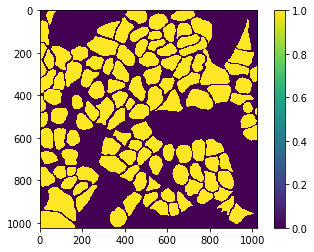

Input: ((1024, 1024, 1), dtype('uint8'))
Output: (1024, 1024, 4)
28
phase
gfp
rfp
Unique labels in mask: [1]


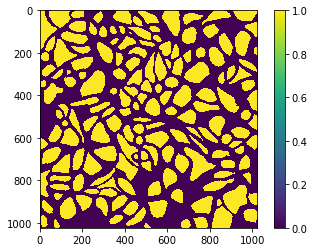

Input: ((1024, 1024, 1), dtype('uint8'))
Output: (1024, 1024, 4)
29
phase
gfp
rfp
Unique labels in mask: [1]


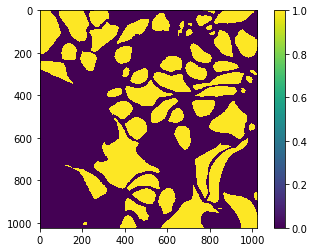

Input: ((1024, 1024, 1), dtype('uint8'))
Output: (1024, 1024, 4)
30
phase
gfp
rfp
Unique labels in mask: [1]


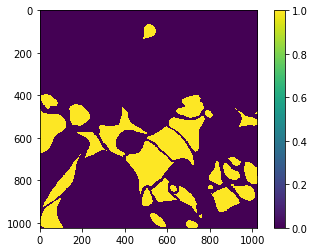

Input: ((1024, 1024, 1), dtype('uint8'))
Output: (1024, 1024, 4)
31
phase
gfp
rfp
Unique labels in mask: [1]


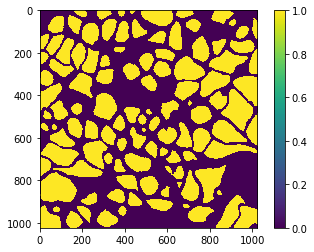

Input: ((1024, 1024, 1), dtype('uint8'))
Output: (1024, 1024, 4)
32
phase
gfp
rfp
Unique labels in mask: [1]


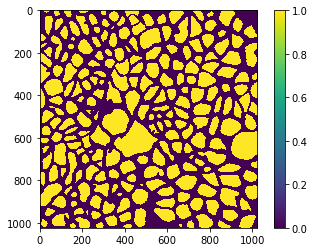

Input: ((1024, 1024, 1), dtype('uint8'))
Output: (1024, 1024, 4)
33
phase
gfp
rfp
Unique labels in mask: [1]


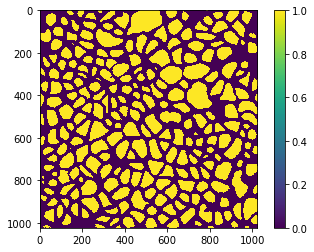

Input: ((1024, 1024, 1), dtype('uint8'))
Output: (1024, 1024, 4)
34
phase
gfp
rfp
Unique labels in mask: [1]


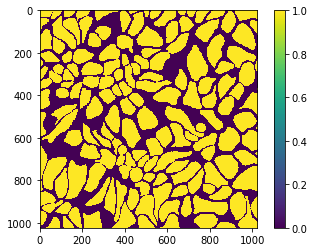

Input: ((1024, 1024, 1), dtype('uint16'))
Output: (1024, 1024, 4)
35
phase
gfp
rfp
Unique labels in mask: [1]


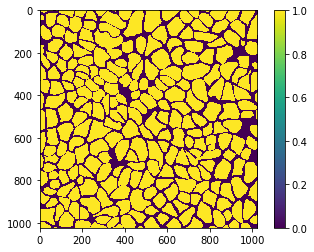

Input: ((1024, 1024, 1), dtype('uint16'))
Output: (1024, 1024, 4)


In [7]:
write_tfrecord(DATA_PATH, tfrecord_fn, metadata)